In [1]:
! pip install transformers

In [2]:
import os
import tensorflow as tf
from tensorflow.keras import backend
import matplotlib.pyplot as plt

2023-11-05 20:54:57.661129: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2023-11-05 20:54:57.661146: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.


*Dataset*
reading the image file

In [33]:
def load_image_file(image_path, mask_path):
    image = tf.io.read_file(image_path)
    mask = tf.io.read_file(mask_path)

    image = tf.image.decode_jpeg(image, channels=3)
    mask = tf.image.decode_png(mask, channels=1)

    return {"image": image, "segmentation_mask": mask}

In [38]:
train_image_dir = "data/train/image"
train_mask_dir = "data/train/mask"
valid_image_dir = "data/valid/image"
valid_mask_dir = "data/valid/mask"
test_image_dir = "data/test/image"
test_mask_dir = "data/test/mask"


# Define list of image and mask file names
train_image_names = sorted(os.listdir(train_image_dir))
train_mask_names = sorted(os.listdir(train_mask_dir))

valid_image_names = sorted(os.listdir(valid_image_dir))
valid_mask_names = sorted(os.listdir(valid_mask_dir))

test_image_names = sorted(os.listdir(test_image_dir))
test_mask_names = sorted(os.listdir(test_mask_dir))


In [41]:
# Define a function to construct the mask name from the image name
def construct_mask_name(image_name):
    base_name = os.path.splitext(image_name)[0]
    mask_name = base_name + "_mask.png"
    return mask_name

# Function to create pairs from a list of image names and corresponding mask names
def create_pairs(image_names, mask_names, image_dir, mask_dir):
    pairs = []
    for img_name in image_names:
        mask_name = construct_mask_name(img_name)
        if mask_name in mask_names:
            pairs.append((os.path.join(image_dir, img_name), os.path.join(mask_dir, mask_name)))
    return pairs

# Create train, valid, and test pairs
train_pairs = create_pairs(train_image_names, train_mask_names, train_image_dir, train_mask_dir)
valid_pairs = create_pairs(valid_image_names, valid_mask_names, valid_image_dir, valid_mask_dir)
test_pairs = create_pairs(test_image_names, test_mask_names, test_image_dir, test_mask_dir)

# Load image and mask data from file paths
data_train = [load_image_file(image_path, mask_path) for image_path, mask_path in train_pairs]
data_valid = [load_image_file(image_path, mask_path) for image_path, mask_path in valid_pairs]
data_test = [load_image_file(image_path, mask_path) for image_path, mask_path in test_pairs]

len(data_train), len(data_valid), len(data_test)


(7926, 1060, 1014)

Normalization 

In [42]:
image_size = 256
mean = tf.constant([0.485, 0.456, 0.406])
std = tf.constant([0.229, 0.224, 0.225])


def normalize(input_image, input_mask):
    input_image = tf.image.convert_image_dtype(input_image, tf.float32)
    input_image = (input_image - mean) / tf.maximum(std, backend.epsilon())
    input_mask = input_mask / 255
    return input_image, input_mask


def load_image(datapoint):
    input_image = tf.image.resize(datapoint["image"], (image_size, image_size))
    input_mask = tf.image.resize(
        datapoint["segmentation_mask"],
        (image_size, image_size),
        method="bilinear",
    )
    input_image, input_mask = normalize(input_image, input_mask)
    input_image = tf.transpose(input_image, (2, 0, 1))
    
    return {"pixel_values": input_image, "labels": tf.squeeze(input_mask)}

In [43]:
train_data = [load_image(datapoint) for datapoint in data_train]
valid_data = [load_image(datapoint) for datapoint in data_valid]
test_data = [load_image(datapoint) for datapoint in data_test]

In [52]:
def generator_train():
    for datapoint in train_data:
        yield datapoint
        
def generator_valid():
    for datapoint in valid_data:
        yield datapoint
        
def generator_test():
    for datapoint in test_data:
        yield datapoint

In [53]:
batch_size = 4
auto = tf.data.AUTOTUNE

train_ds = tf.data.Dataset.from_generator(generator_train, output_types={"pixel_values": tf.float32, "labels": tf.int32}).cache().shuffle(batch_size * 10).batch(batch_size).prefetch(auto)
    
valid_ds = tf.data.Dataset.from_generator(generator_valid, output_types={"pixel_values": tf.float32, "labels": tf.int32}).batch(batch_size).prefetch(auto)
    
test_ds = tf.data.Dataset.from_generator(generator_test, output_types={"pixel_values": tf.float32, "labels": tf.int32}).batch(batch_size).prefetch(auto)

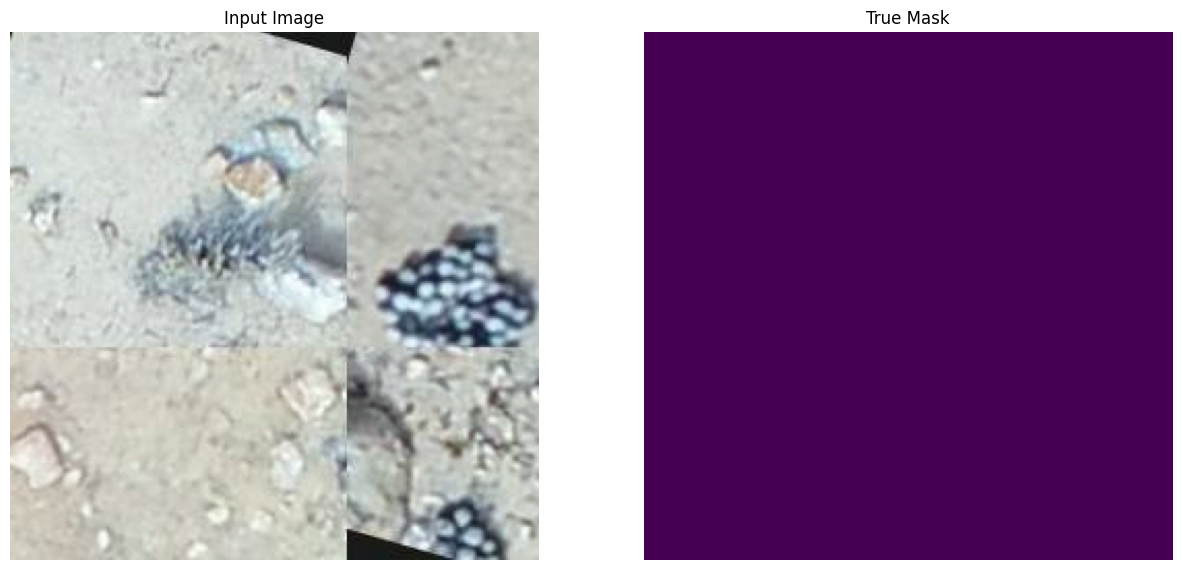

(256, 256, 3)


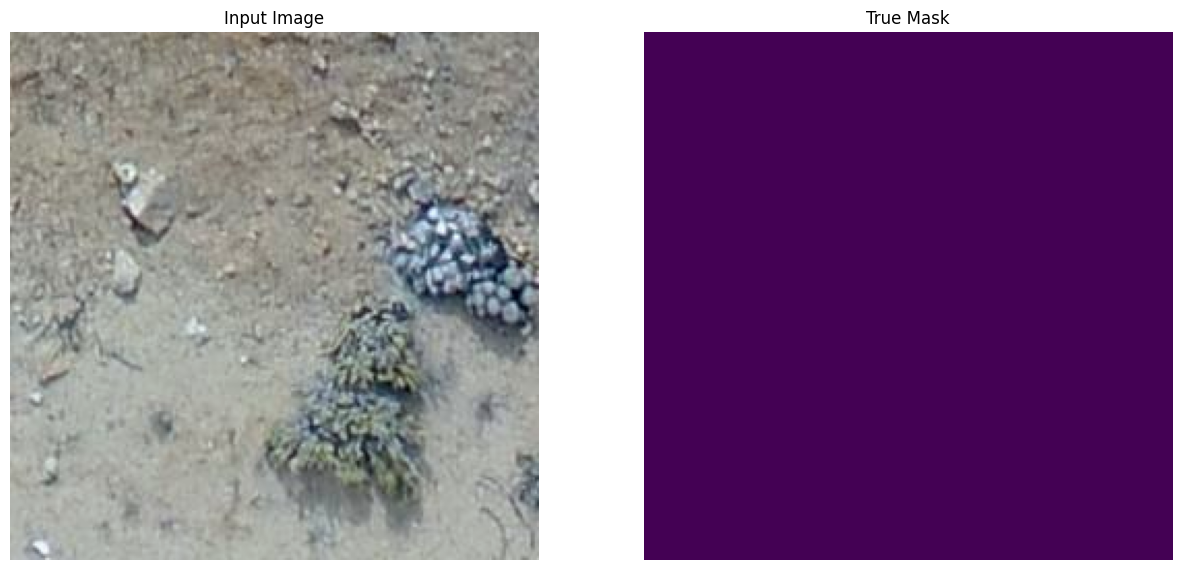

(256, 256, 3)


2023-11-05 21:45:01.559917: W tensorflow/core/kernels/data/cache_dataset_ops.cc:768] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


In [55]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ["Input Image", "True Mask", "Predicted Mask"]

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i + 1)
        plt.title(title[i])
        plt.imshow(tf.keras.utils.array_to_img(display_list[i]))
        plt.axis("off")
    plt.show()


for samples in train_ds.take(2):
    sample_image, sample_mask = samples["pixel_values"][0], samples["labels"][0]
    sample_image = tf.transpose(sample_image, (1, 2, 0))
    sample_mask = tf.expand_dims(sample_mask, -1)
    display([sample_image, sample_mask])
    print(sample_image.shape)

In [56]:
from transformers import TFSegformerForSemanticSegmentation

model_checkpoint = "nvidia/mit-b1"
id2label =  {0: "background", 1: "copiapoa"}
label2id = {label: id for id, label in id2label.items()}
num_labels = len(id2label)
model = TFSegformerForSemanticSegmentation.from_pretrained(
    model_checkpoint,
    num_labels=num_labels,
    id2label=id2label,
    label2id=label2id,
    ignore_mismatched_sizes=True,
    
)

Some layers from the model checkpoint at nvidia/mit-b1 were not used when initializing TFSegformerForSemanticSegmentation: ['classifier']
- This IS expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFSegformerForSemanticSegmentation from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some layers of TFSegformerForSemanticSegmentation were not initialized from the model checkpoint at nvidia/mit-b1 and are newly initialized: ['decode_head']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
lr = 0.01
epochs = 5
optimizer = tf.keras.optimizers.Adam(learning_rate=lr)
model.compile(optimizer=optimizer)